In [729]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [730]:
class DSO:
	def __init__(self, totalHours, marginalCost, unitSalePrice, maxPriceReference):
		self.totalHours = totalHours
		self.numberOfAggregators = 0
		self.marginalCost = marginalCost
		self.unitSalePrice = unitSalePrice
		self.maxPriceReference = maxPriceReference
		self.aggregators = []
		self.maxUtility = 0
		self.m = 0

	def addAggregator(self, aggregator):
		self.aggregators.append(aggregator)
		self.numberOfAggregators = self.numberOfAggregators + 1

	def getAggregators(self):
		return self.aggregators

	def Sfunction(self, aggregator, tIndex):
		return aggregator.maximumDemand[tIndex] * aggregator.maxPriceReference * (1 - np.exp(-aggregator.preferenceSatisfaction[tIndex] * (aggregator.bestLoadResponse[tIndex] / aggregator.nominalDemand[tIndex])))
	
	def CostFunction(self, aggregator, tIndex):
		return self.marginalCost[tIndex]
	
	def getLeftLimit(self):
		leftLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.maximumDemand[i] / agg.nominalDemand[i])))
			leftLimit[i] = mx
		return leftLimit
	
	def getRightLimit(self):
		rightLimit = [0 for i in range(self.totalHours)]
		for i in range(self.totalHours):
			mx = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				mx = max(mx, agg.preferenceSatisfaction[i] * agg.maxPriceReference * np.exp(-agg.preferenceSatisfaction[i] * (agg.minimumDemand[i] / agg.nominalDemand[i])))
			rightLimit[i] = mx
		return rightLimit
	
	def generateUnitSalePrice(self):
		minPrice = self.marginalCost
		leftLimit = self.getLeftLimit()
		minPrice = np.minimum(minPrice, leftLimit)

		maxPrice = self.maxPriceReference
		rightLimit = self.getRightLimit()
		maxPrice = np.maximum(maxPrice, rightLimit)

		for i in range(self.totalHours):
			self.unitSalePrice[i] = random.uniform(minPrice[i], maxPrice[i])

	def generateM(self):
		m = 0
		mx = 0
		for i in range(self.totalHours):
			sum = 0
			for j in range(self.numberOfAggregators):
				agg = self.aggregators[j]
				sum = sum + agg.bestLoadResponse[i]
			mx = max(mx, sum)
		m = random.uniform(mx, 100000)
		self.m = m

	def utilityFunction(self, m, theta, omega):
		# self.generateUnitSalePrice()
		self.generateM()

		# store value of INT_MIN in mx
		mx = -1000000000000
		for j in range(self.totalHours):
			sum = 0
			for i in range(self.numberOfAggregators):
				agg = self.aggregators[i]
				sum = sum + self.unitSalePrice[j] * agg.bestLoadResponse[j] - self.CostFunction(agg, j) * agg.bestLoadResponse[j] + omega * self.Sfunction(agg, j)
			sum = sum - theta*m
			mx = max(mx, sum)
		return mx

	def getPAR(self):
		# sum of all bestResponses for each hour for each aggregator
		sum = 0
		for i in range(self.totalHours):
			for j in range(self.numberOfAggregators):
				sum = sum + self.aggregators[j].bestLoadResponse[i]
		return (self.m * self.totalHours) / (sum)

class Aggregator:
	def __init__(self, totalHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction):
		self.totalHours = totalHours
		self.nominalDemand = nominalDemand
		self.minimumDemand = minimumDemand
		self.maximumDemand = maximumDemand
		self.maxPriceReference = maxPriceReference
		self.preferenceSatisfaction = preferenceSatisfaction
		self.currentUtility = 0
		self.bestLoadResponse = []

	def utilityFunction(self, DSO):
		sum = 0
		for i in range(DSO.totalHours):
			sum = sum + DSO.Sfunction(self, i) - (DSO.unitSalePrice[i] * self.bestLoadResponse[i])
		return sum

	def optimalDR(self, DSO):
		self.bestLoadResponse = []
		for j in range(DSO.totalHours):
			self.bestLoadResponse.append((self.nominalDemand[j] / self.preferenceSatisfaction[j]) * (np.log((self.preferenceSatisfaction[j] * self.maxPriceReference) / DSO.unitSalePrice[j])))


In [731]:
datasetPath = '../dataset/'

In [732]:
numOfLA = 3
numOfHours = 500

In [733]:
nominalDemands = []
for i in range (0, 3):
	letter = chr(ord('A') + i)
	fileName = 'Home' + letter + '_hourly.csv'
	df = pd.read_csv(datasetPath + fileName)
	df = df[0:numOfHours]
	nominalDemands.append(df['Power'].tolist())

In [734]:
LAs = []
maxPriceReference = np.random.randint(1, 1000)
for i in range(numOfLA):
	nominalDemand = nominalDemands[i]
	# find max of nominalDemand
	maxNominalDemand = max(nominalDemand)
	minimumDemand = np.random.uniform(0.01, nominalDemand, numOfHours)
	maximumDemand = np.random.uniform(nominalDemand, maxNominalDemand+1, numOfHours)
	preferenceSatisfaction = np.random.uniform(0.1, 1, numOfHours)
	LAs.append(Aggregator(numOfHours, nominalDemand, minimumDemand, maximumDemand, maxPriceReference, preferenceSatisfaction))


In [735]:
# # print all the values for each LA
# for i in range(numOfLA):
# 	print("LA", i)
# 	print("nominal demand: ", LAs[i].nominalDemand)
# 	print("minimum demand: ", LAs[i].minimumDemand)
# 	print("maximum demand: ", LAs[i].maximumDemand)
# 	print("max price reference: ", LAs[i].maxPriceReference)
# 	print("preference satisfaction: ", LAs[i].preferenceSatisfaction)

In [736]:
marginalCost = np.random.randint(1, 1000, numOfHours)
unitSalePrice = np.random.randint(1, 100, numOfHours)
dso = DSO(numOfHours, marginalCost, unitSalePrice, maxPriceReference)

In [737]:
# append all the LAs to the DSO
for i in range(numOfLA):
	dso.addAggregator(LAs[i])

In [738]:
# # print all the values for the DSO
# print("DSO")
# print("marginal cost: ", dso.marginalCost)
# print("unit sale price: ", dso.unitSalePrice)


In [739]:
dso.generateUnitSalePrice()

In [740]:
# print unit sale price for the DSO
print("unit sale price: ", dso.unitSalePrice)

unit sale price:  [169 111 235 317 274 360 346 346 132 246 301 108 303 352 363 123 236 207
 273  79 343 104 143 234 260 341 223 191  61 146 106 225 269 331  92 136
 124 370 188 325 311 366 274 303 247 162 162  35 372  79  42 221 344 243
 294 302 332  83 242 358 218 286 188 220 126 306 111 243 216 175 198 311
 215 364 184 353 280 363 237 200 203 373 179 245 203 277 356 233 232 365
 307 217 187  73 278 145  73  97 259 281 363 130 195 260 130 136 289 178
 123 147 147 316 366 105 297 316 296  52 264 302 238 269  78  65 217 306
 168 158 284 312 333 238 121 198 250 122 144 140 233  96 118 327 236 150
 229 225  95  98  85 278 238 172 182 136 309 279 235 272 191 159 357 125
 212 325 371 299 327 173 180 349 186 194 116 152 330  53 128 266 194 169
 157 122 317 232 127 303 246 332 290 239 260 293 321 203 224 339 125 201
 312 291 233 222  19 345 353 330 282 147 307 209 164  82 170 252 178 206
  60  96 228 153 275 292 178 268 188 181 345 187 147 193 172 101 255 108
 106 205 348 240 244 189 155 196 

In [741]:
dso.maxPriceReference

374

In [742]:
LAs[0].preferenceSatisfaction

array([0.63739484, 0.61863995, 0.63830692, 0.48082145, 0.88976287,
       0.133335  , 0.91462776, 0.12165183, 0.66017382, 0.56072504,
       0.26520181, 0.77493946, 0.71842049, 0.19244011, 0.11779175,
       0.28665172, 0.17611425, 0.5719694 , 0.54715403, 0.99122737,
       0.66499779, 0.92407871, 0.22729491, 0.2748299 , 0.62270118,
       0.7595194 , 0.42799373, 0.51306926, 0.61323476, 0.38080046,
       0.48899529, 0.41160448, 0.90616574, 0.68972043, 0.88023486,
       0.67193126, 0.31686141, 0.25682535, 0.12568521, 0.5714269 ,
       0.15001704, 0.77428905, 0.6528519 , 0.26777806, 0.26516285,
       0.66115987, 0.70835199, 0.10350331, 0.15905979, 0.30835832,
       0.79507761, 0.40554823, 0.52022321, 0.38749984, 0.49917198,
       0.39547791, 0.928373  , 0.47032807, 0.86458402, 0.65422234,
       0.31545906, 0.5752794 , 0.65192549, 0.35687041, 0.62501456,
       0.95911332, 0.24886515, 0.31378359, 0.8488816 , 0.1506918 ,
       0.31543189, 0.60228231, 0.21541473, 0.81993949, 0.14251

In [743]:
# print(dso.aggregators)

In [744]:
# DSO gives the price for each hour & each LA calculates the optimal DR
for i in range(numOfLA):
	# la = LAs[i]
	la = dso.aggregators[i]
	la.optimalDR(dso)

In [745]:
# print best load response for each LA
for i in range(numOfLA):
	print("LA", i)
	print("best load response: ", LAs[i].bestLoadResponse)

LA 0
best load response:  [0.2039769808698816, 0.42583563701373617, 0.00792117903138885, -0.35253960762348585, 0.06594851001644185, -4.729747427738043, -0.006204401111786176, -9.363318283160254, 0.7524080708526387, -0.181475950443053, -2.2074393486561075, 0.8197638032573951, -0.05818884157964101, -2.7756113277835426, -11.823777859456362, -0.34663003111672147, -5.249700555004159, 0.04436872147905261, -0.423087083642026, 0.8944876584926544, -0.2309106559015139, 0.5220041618356103, -0.8067709754655399, -1.0578719715954017, -0.05903599826749787, -0.08020148194565614, -0.24502408270313264, 0.0025677117121246044, 0.6324175813973695, -0.020440613898129963, 0.48385782969313534, -0.38023748565650684, 0.1514155301606657, -0.18228566063536078, 0.754673608704715, 0.4190100481891589, -0.06385330239099526, -2.849595309658895, -5.763125338547993, -0.2698201781164132, -3.9928426681497076, -0.16619715496371273, -0.08943385305769974, -1.8089692535541604, -1.6831429261249597, 0.28983898048740775, 0.28725

In [746]:
# print best load response for each LA
for i in range(numOfLA):
	print("LA", i)
	print("best load response: ", dso.aggregators[i].bestLoadResponse)

LA 0
best load response:  [0.2039769808698816, 0.42583563701373617, 0.00792117903138885, -0.35253960762348585, 0.06594851001644185, -4.729747427738043, -0.006204401111786176, -9.363318283160254, 0.7524080708526387, -0.181475950443053, -2.2074393486561075, 0.8197638032573951, -0.05818884157964101, -2.7756113277835426, -11.823777859456362, -0.34663003111672147, -5.249700555004159, 0.04436872147905261, -0.423087083642026, 0.8944876584926544, -0.2309106559015139, 0.5220041618356103, -0.8067709754655399, -1.0578719715954017, -0.05903599826749787, -0.08020148194565614, -0.24502408270313264, 0.0025677117121246044, 0.6324175813973695, -0.020440613898129963, 0.48385782969313534, -0.38023748565650684, 0.1514155301606657, -0.18228566063536078, 0.754673608704715, 0.4190100481891589, -0.06385330239099526, -2.849595309658895, -5.763125338547993, -0.2698201781164132, -3.9928426681497076, -0.16619715496371273, -0.08943385305769974, -1.8089692535541604, -1.6831429261249597, 0.28983898048740775, 0.28725

In [747]:
# DSO takes back the load response from each aggregator
m = np.random.randint(1, 100)
# theta = np.random.uniform(0.1, 1)
# omega = np.random.uniform(0.1, 1)
theta = 0.01
omega = 5
dso.maxUtility = dso.utilityFunction(m, theta, omega)
dso.maxUtility

22734.251931718914

In [748]:
# print utility for each house
for i in range(numOfLA):
	print("LA", i)
	ut = LAs[i].utilityFunction(dso)
	print("utility: ", ut)

LA 0
utility:  -26003.753762215147
LA 1
utility:  -333991.6866234857
LA 2
utility:  -34601.66265817696


In [749]:
dso.getPAR()

-15046.288538800905

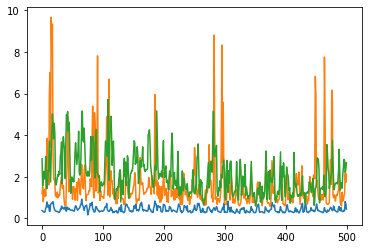

In [750]:
# plot nominal demand of each LA
for i in range(numOfLA):
	plt.plot(LAs[i].nominalDemand)
plt.show()

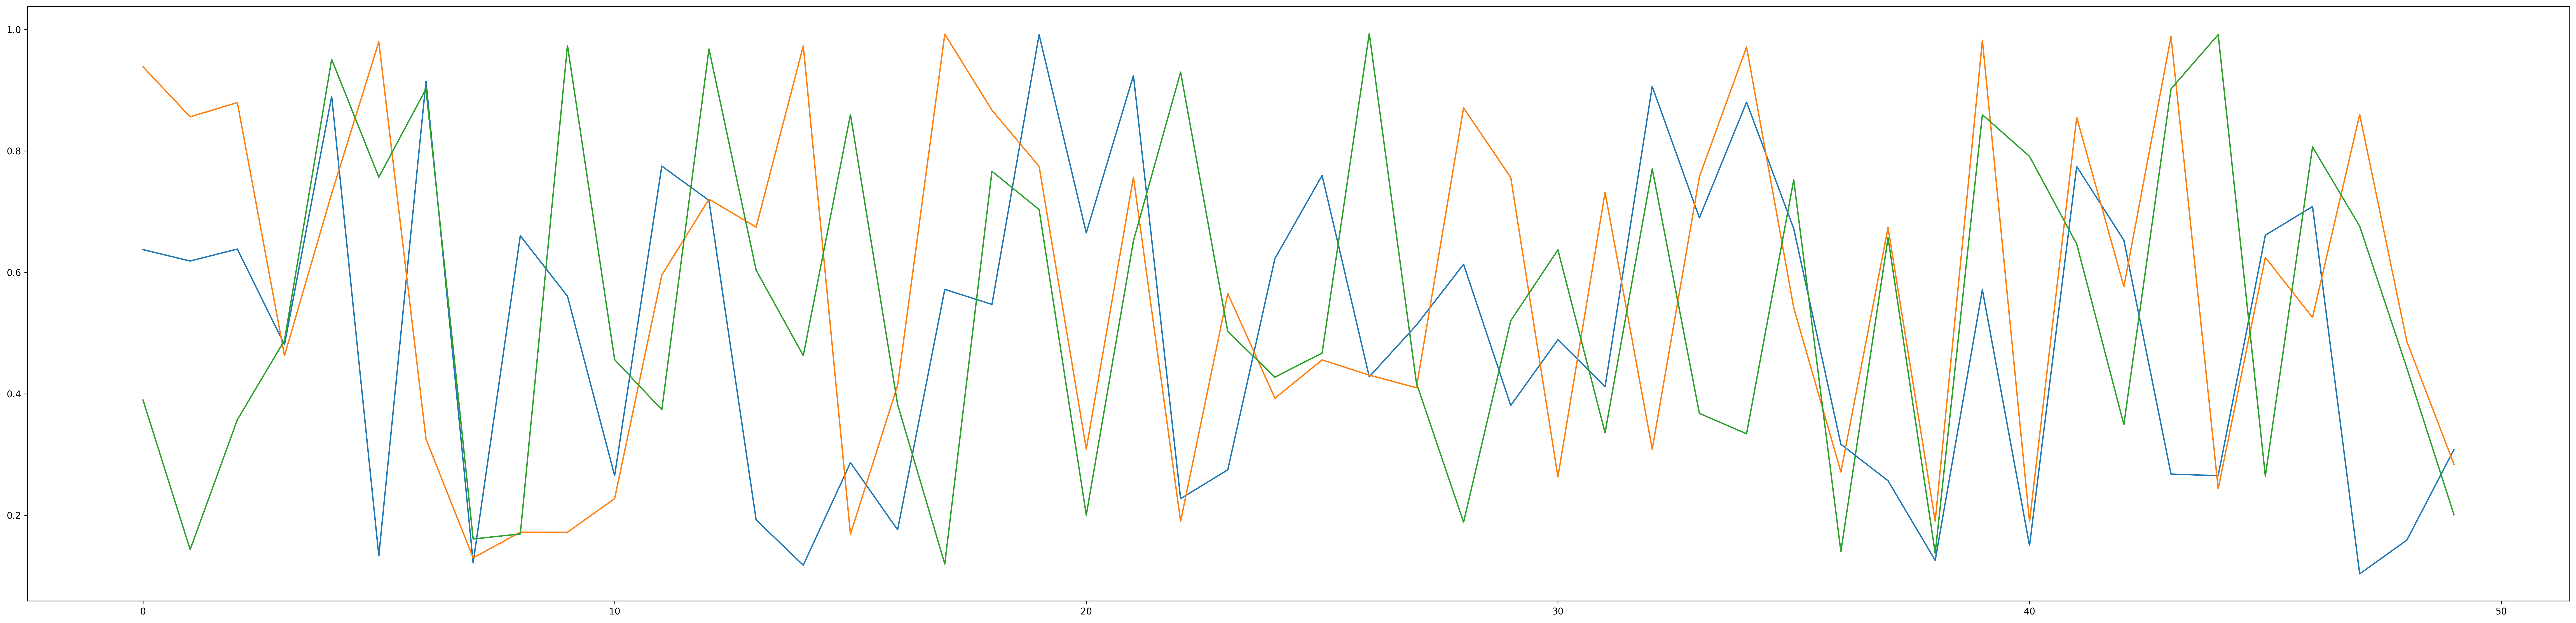

In [751]:
# plot user pref of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].preferenceSatisfaction[0:50])
plt.show()

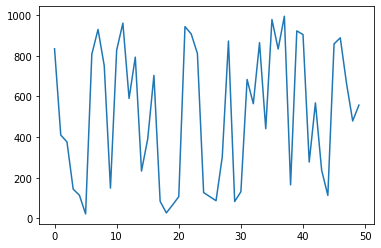

In [752]:
# plot marginal cost
plt.plot(dso.marginalCost[0:50])
plt.show()

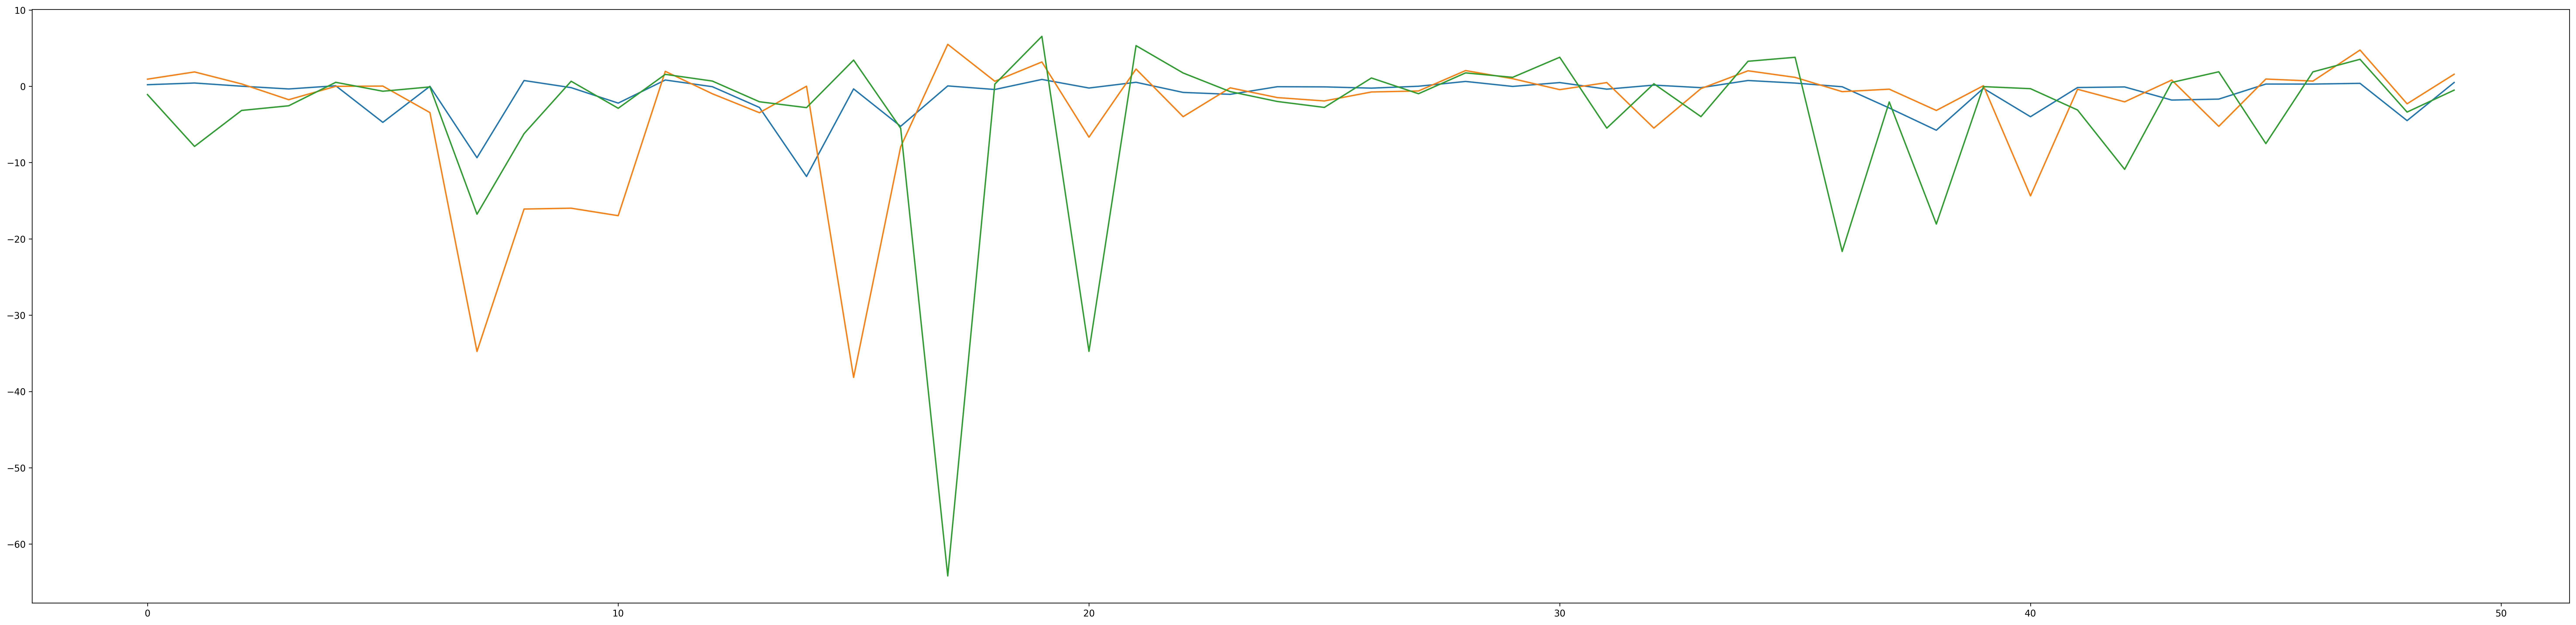

In [753]:
# plot bestLoadResponse of each LA
plt.figure(figsize=(50, 12), dpi=300)
for i in range(numOfLA):
	plt.plot(LAs[i].bestLoadResponse[0:50])
plt.show()